In [1]:
# Checklist:
# AWS emr-5.29.0
# MASTER r5d.8xlarge 1x, no EBS
# CORE r5d.8xlarge 4x, no EBS
# Custom bootstrap action: s3://ydatazian/bootstrap.sh
# Allow ssh in master node security group

# I couldn't use r5d.8xlarge because there were no available instances. So I used r5d.4xlarge

In [1]:
import tqdm.notebook as tqdm
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt

# SparkSession

https://spark.apache.org/docs/2.4.4/api/python/pyspark.html

https://spark.apache.org/docs/2.4.4/api/python/pyspark.sql.html

In [2]:
import findspark
findspark.init()

import spark_utils
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
sc = SparkContext("yarn", "My App", conf=spark_utils.get_spark_conf())
se = SparkSession(sc)
spark_utils.print_ui_links()

NameNode: http://ec2-3-84-136-26.compute-1.amazonaws.com:50070
YARN: http://ec2-3-84-136-26.compute-1.amazonaws.com:8088
Spark UI: http://ec2-3-84-136-26.compute-1.amazonaws.com:20888/proxy/application_1589612302934_0001


# Ephemeral local HDFS

In [3]:
! hdfs dfs -df -h

Filesystem                                  Size     Used  Available  Use%
hdfs://ip-172-31-33-134.ec2.internal:8020  2.2 T  444.5 M      2.2 T    0%


In [4]:
! hdfs dfs -ls /

Found 3 items
drwxrwxrwt   - hdfs hadoop          0 2020-05-16 06:58 /tmp
drwxr-xr-x   - hdfs hadoop          0 2020-05-16 06:58 /user
drwxr-xr-x   - hdfs hadoop          0 2020-05-16 06:58 /var


# Persistent S3

https://www.kaggle.com/c/outbrain-click-prediction/data

In [5]:
! aws s3 ls s3://ydatazian

2020-05-09 13:43:02       1732 bootstrap.sh
2020-05-07 21:18:30  176843889 clicks_test.parquet
2020-05-07 21:18:30  495815517 clicks_train.parquet
2020-05-07 21:18:30   34267065 documents_categories.parquet
2020-05-07 21:18:30  206455957 documents_entities.parquet
2020-05-07 21:18:30   23859965 documents_meta.parquet
2020-05-07 21:18:31  187410196 documents_topics.parquet
2020-05-07 21:18:32  734643471 events.parquet
2020-05-07 21:18:35 50764611872 page_views.parquet
2020-05-07 21:18:35  248421413 page_views_sample.parquet
2020-05-07 21:18:36    5116927 promoted_content.parquet
2020-05-07 21:18:36  273136709 sample_submission.csv


# Read directly from S3

In [45]:
df = se.read.parquet("s3://ydatazian/page_views.parquet")
df.show(5)

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
+--------------+-----------+---------+--------+------------+--------------+
only showing top 5 rows



# Register all tables for sql queries

In [7]:
from IPython.display import display
tables = ["clicks_test", "clicks_train", 
          "documents_categories", "documents_topics", "documents_meta", "documents_topics", 
          "events", "page_views", "page_views_sample", "promoted_content"]
for name in tqdm.tqdm(tables):
    df = se.read.parquet("s3://ydatazian/{}.parquet".format(name))
    df.registerTempTable(name)
    print(name)
    display(df.limit(3).toPandas())

clicks_test


,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754


clicks_train


,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1


documents_categories


,document_id,category_id,confidence_level
0,1595802,1611,0.92
1,1595802,1610,0.07
2,1524246,1807,0.92


documents_entities


,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865314504701
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399113728441297
2,1524246,839907a972930b17b125eb0247898412,0.392095749652966


documents_meta


,document_id,source_id,publisher_id,publish_time
0,1595802,1,603,2016-06-05 00:00:00
1,1524246,1,603,2016-05-26 11:00:00
2,1617787,1,603,2016-05-27 00:00:00


documents_topics


,document_id,topic_id,confidence_level
0,1595802,140,0.0731131601068925
1,1595802,16,0.0594164867373976
2,1595802,143,0.0454207537554526


events


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505


page_views


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


page_views_sample


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


promoted_content


,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7


# Simple SQL query

In [8]:
%%time
df = se.sql(
"""
select 
    uuid, 
    count(1) as cnt
from page_views
group by uuid
""")
df.write.parquet("/count_per_user.parquet", mode='overwrite')

CPU times: user 13 ms, sys: 4.44 ms, total: 17.4 ms
Wall time: 1min 58s


In [9]:
%%time
se.read.parquet("/count_per_user.parquet").show(5)

+--------------+---+
|          uuid|cnt|
+--------------+---+
|38edd7ea60932c| 38|
|ac0a7fb929798c| 28|
|efb3bcdecd9dab|  1|
|6a4a65c4e358e3| 23|
|621095d704c3e4| 39|
+--------------+---+
only showing top 5 rows

CPU times: user 1.95 ms, sys: 930 µs, total: 2.88 ms
Wall time: 592 ms


In [10]:
! hdfs dfs -ls /

Found 4 items
drwxr-xr-x   - hadoop hadoop          0 2020-05-16 07:25 /count_per_user.parquet
drwxrwxrwt   - hdfs   hadoop          0 2020-05-16 06:58 /tmp
drwxr-xr-x   - hdfs   hadoop          0 2020-05-16 06:58 /user
drwxr-xr-x   - hdfs   hadoop          0 2020-05-16 06:58 /var


# The same in Python (10x slower)

In [11]:
df = se.table("page_views")
print(df)

DataFrame[uuid: string, document_id: string, timestamp: string, platform: string, geo_location: string, traffic_source: string]


In [12]:
rdd = df.rdd
print(rdd)
print(rdd.take(1))  # sent to driver (our Jupyter kernel)
print(rdd.take(1)[0].uuid)  # Python object

MapPartitionsRDD[81] at javaToPython at NativeMethodAccessorImpl.java:0
[Row(uuid='1fd5f051fba643', document_id='120', timestamp='31905835', platform='1', geo_location='RS', traffic_source='2')]
1fd5f051fba643


In [ ]:
%%time
! hdfs dfs -rm -r /count_per_user.pickle
se.table("page_views").rdd\
    .map(lambda x: (x.uuid, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .saveAsPickleFile("/count_per_user.pickle")

Deleted /count_per_user.pickle


In [ ]:
%%time
sc.pickleFile("/count_per_user.pickle").take(5)

In [ ]:
# and we can convert it back to Spark DataFrame
from pyspark.sql import Row
rdd_of_rows = sc.pickleFile("/count_per_user.pickle")\
    .map(lambda x: Row(uuid=x[0], cnt=x[1]))
df = se.createDataFrame(rdd_of_rows)
df.write.parquet("/count_per_user_converted.parquet", mode='overwrite')

In [ ]:
df = se.read.parquet("/count_per_user_converted.parquet")
df.printSchema()
df.show(5)

In [ ]:
! hdfs dfs -du -s -h "/*"

# Collect data on the driver

In [ ]:
%%time
counts = se.read.parquet("/count_per_user_converted.parquet").rdd\
    .map(lambda x: x.cnt)\
    .collect()

In [ ]:
_ = plt.hist(counts, bins=100)

# SQL + Python hybrid

In [ ]:
se.table("page_views").show(5)

In [ ]:
df = se.sql(
"""
select 
    uuid, 
    collect_list(struct(document_id, timestamp, platform, geo_location, traffic_source)) as views
from page_views
group by uuid
""")
df.printSchema()

In [ ]:
%%time
! hdfs dfs -rm -r /platforms_per_user.pickle
from collections import defaultdict

def mapper(x):
    d = defaultdict(int)
    for row in x.views:
        d[row.platform] += 1
    return (x.uuid, d)

df.rdd.map(mapper).saveAsPickleFile("/platforms_per_user.pickle")

# The same in Python (5x slower)

In [ ]:
%%time
! hdfs dfs -rm -r /platforms_per_user2.pickle

def mapper(x):
    d = defaultdict(int)
    for row in x[1]:
        d[row.platform] += 1
    return (x[0], d)

(
    se
    .table("page_views")
    .rdd
    .groupBy(lambda x: x.uuid)
    .map(mapper)
    .saveAsPickleFile("/platforms_per_user2.pickle")
)

# Homework 1: Spark EDA

1. Find 10 most visited document_ids in page_views log

In [19]:
df = se.sql(
"""
SELECT document_id, count(1) as count
FROM page_views
GROUP BY document_id
ORDER BY count desc
LIMIT 10
""")

In [20]:
df.show(10)

+-----------+--------+
|document_id|   count|
+-----------+--------+
|    1179111|26688981|
|     394689|10454691|
|       2191| 5044391|
|       7054| 4996916|
|      38922| 4930261|
|    1154100| 4610780|
|     357569| 4046253|
|    1827718| 3046274|
|        234| 2359994|
|     467462| 2328065|
+-----------+--------+



2. Find 10 most visited topic_ids in page_views log (use documents_topics table)

In [26]:
df = se.sql(
"""
SELECT topic_id, count(1) as count
FROM page_views
INNER JOIN documents_topics WHERE page_views.document_id = documents_topics.document_id
GROUP BY documents_topics.topic_id
ORDER BY count desc
LIMIT 10
""")

In [27]:
df.show(10)

+--------+---------+
|topic_id|    count|
+--------+---------+
|      16|226580657|
|     140|175020525|
|      20|171010359|
|     143|153101583|
|     136|137553975|
|     216|109567943|
|       8|105683622|
|     160| 99645579|
|     181| 98421838|
|      97| 90551102|
+--------+---------+



3. Find out how many users have at least two different traffic_sources in their page_views log

In [37]:
df = se.sql(
"""
SELECT count(uuid)
FROM page_views
GROUP BY uuid
HAVING count(DISTINCT traffic_source) > 2
""")

In [39]:
df.show(10)

+-----------+
|count(uuid)|
+-----------+
|         30|
|         30|
|         11|
|         27|
|         19|
|         46|
|          4|
|         26|
|         28|
|         55|
+-----------+
only showing top 10 rows



4. Find out the average uuid (user) CTR (number of clicks in all of her display_ids / (number of impressions ... + 10)). Plot the distribution of individual CTRs as a histogram (bins=100).

In [84]:
df = se.sql(
"""
SELECT uuid, clicks, impressions 
FROM (SELECT uuid, count (document_id) as clicks FROM page_views GROUP BY uuid),
     (SELECT uuid as uuid2, count (display_id) as impressions FROM events GROUP BY uuid2)
WHERE uuid = uuid2
""")

In [85]:
df.show(5)

+--------------+------+-----------+
|          uuid|clicks|impressions|
+--------------+------+-----------+
|100013af048bbf|    46|          1|
|1000615e760786|     3|          1|
|10015959b777b6|     2|          1|
|100163b35102c4|    12|          1|
|1002bf9af20fa9|    15|          1|
+--------------+------+-----------+
only showing top 5 rows



In [86]:
mapper = lambda x: (x.uuid, x.clicks, x.impressions,  x.clicks / (x.impressions + 10))

df2 = df.rdd.map(mapper).toDF(('uuid', 'clicks', 'impressions', 'ctr'))

In [87]:
# Print all statistics - min, max, mean.
df2.describe().show()

+-------+--------------+------------------+------------------+------------------+
|summary|          uuid|            clicks|       impressions|               ctr|
+-------+--------------+------------------+------------------+------------------+
|  count|      19794967|          19794967|          19794967|          19794967|
|   mean|      Infinity| 9.851647643565155|1.1679800223966021|0.8638197661465664|
| stddev|           NaN|15.453206468653962|0.5917162702974404|1.3108469158325862|
|    min|1000003a6ad6e3|                 1|                 1|              0.05|
|    max|ffffffba166815|               718|                49| 65.27272727272727|
+-------+--------------+------------------+------------------+------------------+



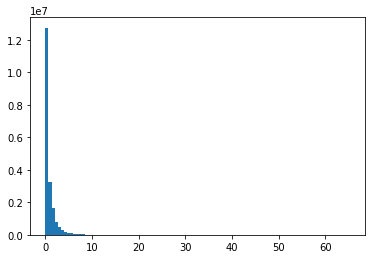

In [88]:
values = df2.rdd.map(lambda x: x.ctr).collect()
plt.hist(values, bins=100)
plt.show()

5. Find out how many page views has an average user before encountering a display_id (use timestamp columns). Plot the distribution of individual values.

In [78]:
df = se.sql(
"""
SELECT page_views.uuid, count (page_views.document_id) as page_views
FROM page_views
WHERE page_views.timestamp < (SELECT min(timestamp) FROM events WHERE events.uuid = page_views.uuid GROUP BY events.uuid)
GROUP BY page_views.uuid
""")

In [79]:
df.show(5)

+--------------+----------+
|          uuid|page_views|
+--------------+----------+
|100013af048bbf|         2|
|1000615e760786|         2|
|10015959b777b6|         1|
|100163b35102c4|        11|
|1002bf9af20fa9|        10|
+--------------+----------+
only showing top 5 rows



In [80]:
# Print all statistics - min, max, mean.
df.describe().show()

+-------+--------------+-----------------+
|summary|          uuid|       page_views|
+-------+--------------+-----------------+
|  count|      14168132|         14168132|
|   mean|      Infinity|5.966677329093208|
| stddev|           NaN| 9.16611505042474|
|    min|1000003a6ad6e3|                1|
|    max|ffffffba166815|              679|
+-------+--------------+-----------------+



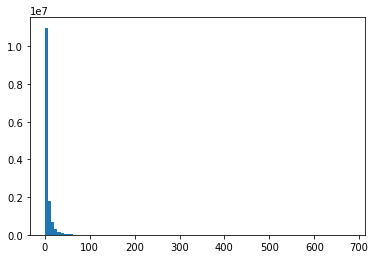

In [81]:
values = df.rdd.map(lambda x: x.page_views).collect()
plt.hist(values, bins=100)
plt.show()